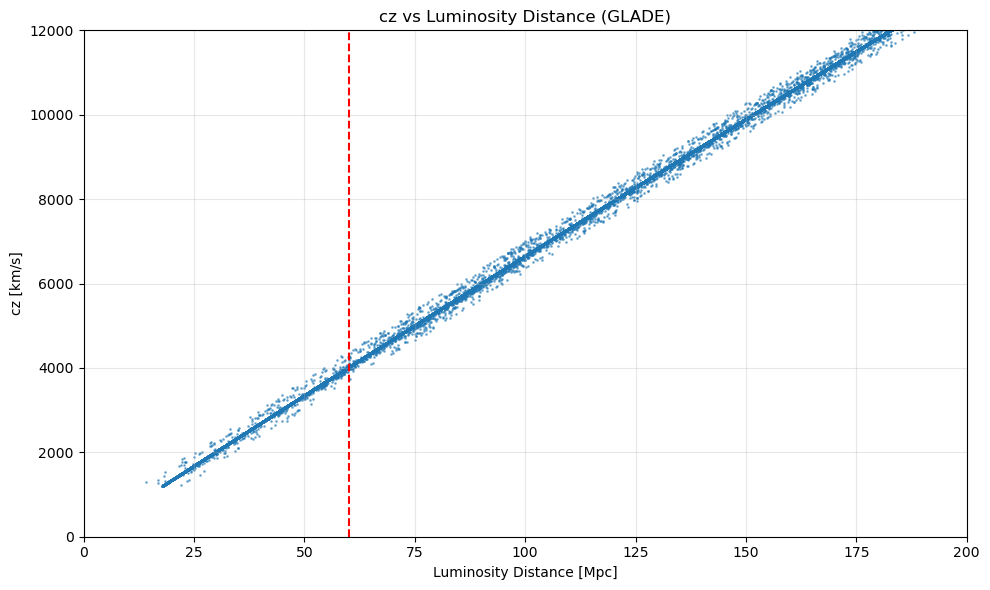

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Config:
    """Configuration parameters for the analysis."""
    GLADE_FILE = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    PLOTS_DIR = "../plots"

    MIN_CZ = 1200
    MAX_CZ = 12000
    MK_CUT = -20.0
    MAX_DEC = 45.0

    MAX_DL = 200.0


def read_GLADE(cols_to_use, cz_min=Config.MIN_CZ,
               dL_max=Config.MAX_DL,
               filename=Config.GLADE_FILE):
    """Read and filter GLADE catalog."""
    from get_masks import get_milkyway_mask

    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        sep=r'\s+',
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        # Distance-flag cut
        chunk = chunk.loc[chunk["dist_flag"] != 0].copy()

        # cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Basic cuts
        chunk = chunk.loc[
            (chunk["cz"] > cz_min) &
            (chunk["d_L"] < dL_max)
        ].copy()

        # Absolute magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Finite values only
        mask = (
            np.isfinite(chunk["M_K"]) &
            np.isfinite(chunk["d_L"]) &
            np.isfinite(chunk["RA"]) &
            np.isfinite(chunk["Dec"])
        )
        filtered_chunks.append(chunk.loc[mask])

    df = pd.concat(filtered_chunks, ignore_index=True)

    # Apply Milky Way mask (assumed boolean)
    mw_mask = get_milkyway_mask(df["RA"].values, df["Dec"].values)
    df = df.loc[mw_mask]

    # Declination cut
    df = df.loc[df["Dec"] < Config.MAX_DEC]

    return df


def plot_cz_vs_dL(df):
    """Plot cz vs luminosity distance."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df["d_L"], df["cz"], s=1, alpha=0.5)
    plt.xlabel("Luminosity Distance [Mpc]")
    plt.ylabel("cz [km/s]")
    plt.title("cz vs Luminosity Distance (GLADE)")
    plt.xlim(0, Config.MAX_DL)
    plt.ylim(0, Config.MAX_CZ)
    plt.axvline(60, color='red', linestyle='--', label='60 Mpc')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    cols_to_use = ["RA", "Dec", "z_cmb", "d_L", "K", "dist_flag"]
    df = read_GLADE(cols_to_use)
    plot_cz_vs_dL(df)
